In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools.load_data import *
from alvra_tools.channels import *

[INFO][corrections] Numba not available, reverting to Numpy


In [3]:
# Take the correct pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals)
# Take the correct gains.h5 file (usually located in /sf/alvra/config/jungfrau/gainMaps/JF02T09V01/)

pede_file = "/das/work/p17/p17983/Example_data/res/JF_pedestals/pedestal_20190706_1050.JF02T09V02.res.h5"

gain_file = "/sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5"

with h5py.File(gain_file, "r") as file: 
    G = file["gains"][:]
    
with h5py.File(pede_file, "r") as file: 
    P = file["gains"][:]
    mask = file["pixel_mask"][:]

print("Dimensions of G: ", G.shape)
print("Dimensions of P: ", P.shape)
print("Dimensions of mask: ", mask.shape)

# Detector name for loading module map and applying geometry
detector_name = "JF02T09V02"

Dimensions of G:  (4, 4608, 1024)
Dimensions of P:  (4, 4608, 1024)
Dimensions of mask:  (4608, 1024)


In [6]:
scan_name = "Ru_foil_monoscan_001"
DIR = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17983/res/scan_info/"

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

There are 84 files in the folder /sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_001/


Right now it seems like the on and off data is flipped coming from the load_JF_data_on_off function.  Will need to fix this.  For now I am just coding is backwards.

In [8]:
numstds = 2
minIzero = 0.002
image_threshold = 4
hot_pixel = 10

json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
numFiles = 1

print ("Processing",numFiles,"files")

Energy_eV_pump = np.empty(0)
Energy_eV_unpump = np.empty(0)

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    filename = DIR + os.path.basename(filename)
    exists = os.path.isfile(filename)
    if not exists:
        print("No such file")
    elif exists and i!=39: #Do we need this 39?
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))

    images_off, images_on, pulse_ids_off, pulse_ids_on \
        = load_JF_data_on_off(filename.replace("BSREAD", "JF02T09V02"), 50, 25, nshots=None)

    (DataFluo_pump, DataFluo_unpump, IzeroFEL_pump, IzeroFEL_unpump, BS_pulse_ids_pump, BS_pulse_ids_unpump, Energy_pump, Energy_unpump, _, _) \
        = load_PumpProbe_events_withTwoVariables(filename, channel_BS_pulse_ids, channel_energy)
    
    X = [a==b and c==d for a,b,c,d in zip(pulse_ids_on, BS_pulse_ids_pump, pulse_ids_off, BS_pulse_ids_unpump)]
    if sum([int(x) for x in X]) == images_on.shape[0]:
        print('passed pulse id check')
    else:
        print('failed pulse id check')
    
    total_on = 0
    total_off = 0

    IzeroMedian = np.median(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
    IzeroSTD = np.std(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
    
    nframes = images_on.shape[0]
    
# each file has qa list of mono energies, the average of which is loaded as the mono energy
    Energy_pump = [x for x in Energy_pump if (np.abs(x) > 0)]
    Energy_eV_pump = np.append(Energy_eV_pump, np.mean(Energy_pump))
        
    Energy_unpump = [x for x in Energy_unpump if (np.abs(x) > 0)]
    Energy_eV_unpump = np.append(Energy_eV_unpump, np.mean(Energy_unpump))

    for j in range(nframes):

        conditionPumpMax = IzeroFEL_pump[j] < IzeroMedian+numstds*IzeroSTD
        conditionPumpMin = IzeroFEL_pump[j] > IzeroMedian-numstds*IzeroSTD
        conditionPumpLow = IzeroFEL_pump[j] > minIzero

        if conditionPumpMax and conditionPumpMin and conditionPumpLow:

            image_on = images_on[j, :]
            image_on = ju.apply_gain_pede(image_on, G=G, P=P, pixel_mask=mask, highgain=False)
            image_on_thr = image_on.copy()
            image_on_thr[image_on < image_threshold] = 0
            image_on_thr[image_on > hot_pixel] = 0
            total_on += image_on_thr

        conditionUnPumpMax = IzeroFEL_unpump[j] < IzeroMedian+numstds*IzeroSTD
        conditionUnPumpMin = IzeroFEL_unpump[j] > IzeroMedian-numstds*IzeroSTD
        conditionUnPumpLow = IzeroFEL_unpump[j] > minIzero

        if conditionUnPumpMax and conditionUnPumpMin and conditionUnPumpLow:

            image_off = images_off[j, :]
            image_off = ju.apply_gain_pede(image_off, G=G, P=P, pixel_mask=mask, highgain=False)
            image_off_thr = image_off.copy()
            image_off_thr[image_off < image_threshold] = 0
            image_off_thr[image_off > hot_pixel] = 0
            total_off += image_off_thr
            
    total_on_corr = ju.apply_geometry(total_on, detector_name)
    total_off_corr = ju.apply_geometry(total_off, detector_name)
    
    XES_off = np.sum(total_off_corr,axis=0)
    XES_on = np.sum(total_on_corr,axis=0)
    
    if i == 0:
        RIXS_off = XES_off
        RIXS_on = XES_on
    else:
        RIXS_off = np.vstack((RIXS_off,XES_off))
        RIXS_on = np.vstack((RIXS_on,XES_on))

print(RIXS_off.shape)
print(RIXS_on.shape)


/sf/alvra/data/p17983/res/scan_info/Ru_foil_monoscan_001_scan_info.json
Processing 1 files
step 1 of 1 : Processing /sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_001/Ru_foil_monoscan_001_step0000.BSREAD.h5
failed pulse id check


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:


plt.figure()
plt.subplots_adjust(wspace=100)
plt.subplot(211)


x_axis = np.linspace(0,len(RIXS_on)-1,len(RIXS_on))
print(x_axis.shape)



9318
(514, 9318)


<IPython.core.display.Javascript object>


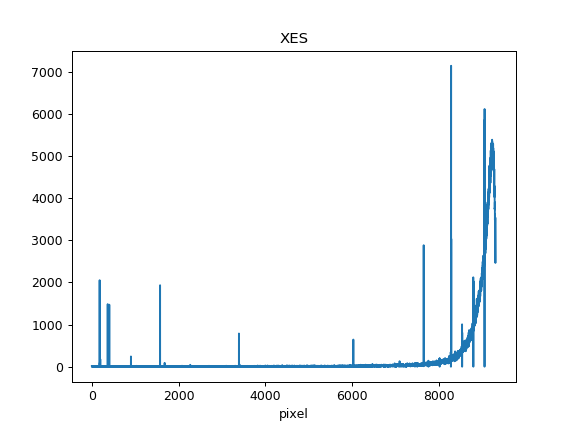

9318
(514, 9318)


<IPython.core.display.Javascript object>


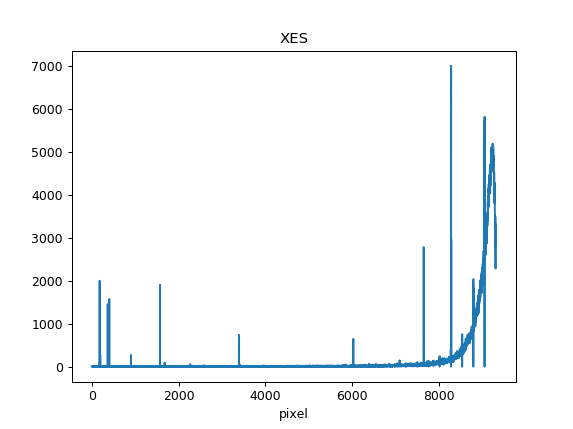

<IPython.core.display.Javascript object>


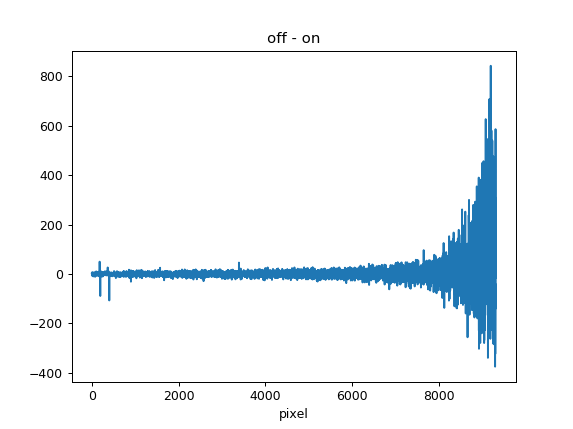

Text(0.5, 1.0, 'off - on')

In [7]:
XES_off = np.sum(total_off_corr,axis=0)
print(XES_off.size)
print(total_off_corr.shape)

plt.figure()
plt.plot(XES_off)
plt.xlabel('pixel')
plt.title('XES')

XES_on = np.sum(total_on_corr,axis=0)
print(XES_on.size)
print(total_on_corr.shape)

plt.figure()
plt.plot(XES_on)
plt.xlabel('pixel')
plt.title('XES')

plt.figure()
plt.plot(XES_off-XES_on)
plt.xlabel('pixel')
plt.title('off - on')

